## Exploratory data analysis: PCA and Mahalanobis distance analysis

**Author:** Y.X. Wu

- **Principal Component Analysis (PCA)**: use PCA to reduce the dimensionality of the feature space. It will allow us to visualize the new data alongside the literature data within the same reduced feature space. PCA does this by transforming the original variables into a new set of uncorrelated variables (i.e., principal components), which are ordered by the amount of variance they can explain from the original data. This allows us to capture most of the information in the original data with fewer dimensions.

- **Uniform Manifold Approximation and Projection (UMAP)**: To better visualise the data in 2D space and perseve the global structure, we also employ UMAP, which is a nonlinear dimensionality reduction method. It excels in preserving the structure of high-dimensional data in low-dimensional space, making it suitable for visualizing clusters or groups within data. Unlike PCA, UMAP can capture nonlinear relationships within the data, making it more capable of separating different classes or clusters. Our UMAP application involves a Mahalanobis distance metric, which respects the covariance of the data, and the implementation scales the data and calculates the inverse covariance matrix as part of its workflow. This technique will further aid in visualizing and understanding the structure of our compositional feature space.

- **Mahalanobis Distance Calculation**: Following the visualization, we'll take a more in-depth look into the data by calculating the Mahalanobis distance for all the new data points from the centroid of the literature data set. The Mahalanobis distance is a measure of the distance between a point and a distribution, not between two distinct points. It's effectively a multivariate equivalent of the Euclidean distance. However, unlike Euclidean distance, the Mahalanobis distance is scale-invariant and takes into account the correlations of the data set. By calculating the Mahalanobis distance, we can quantify how much the new data deviates from the distribution of the literature data.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math
import matplotlib.cm as cm
import matplotlib as mpl
import os
mpl.rcParams['font.family'] = 'FreeSans'

# display the current working directory
display("Current working directory: {0}".format(os.getcwd()))

data_path = '../01_Dataset_Cleaned/'
display(os.path.isfile(data_path+'LiteratureDataset_Hardness_YW_v3_processed.xlsx'))

### Import hardness and corrosion LITERATURE datasets


In [ ]:
# Declare column names for the chemical composition dataframe, specific testing conditions, selected features, and output for Hardness and Corrosion datasets.
compo_column = ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si',
                'Mn', 'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']
C_specific_testing_column = ['TestTemperature_C',
                             'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']
specific_features_sel_column = ['delta_a', 'Tm', 'sigma_Tm',
                                'Hmix', 'sigma_Hmix', 'sigma_elec_nega', 'VEC', 'sigma_VEC']
H_output_column = ['converted HV']
C_output_column = ['AvgPittingPotential_mV']

# Load the Hardness and Corrosion datasets
df_H = pd.read_excel(
    data_path + 'LiteratureDataset_Hardness_YW_v3_processed.xlsx')
df_C = pd.read_excel(
    data_path + 'LiteratureDataset_Corrosion_YW_v3_processed.xlsx')

# Partition the datasets into component composition, specific features, and output data
df_H_compo, df_H_specific_features, df_H_output = df_H[compo_column], df_H[
    specific_features_sel_column], df_H[H_output_column]
(df_C_compo, df_C_specific_testing,
 df_C_specific_features, df_C_output) = df_C[compo_column], df_C[C_specific_testing_column], df_C[specific_features_sel_column], df_C[C_output_column]

df_H_compo_specific_features = pd.concat(
    [df_H_compo, df_H_specific_features], axis=1)
df_C_compo_specific_features = pd.concat(
    [df_C_compo, df_C_specific_features], axis=1)

### Import NEW dataset


In [ ]:
# Specify columns for NiCrCoVFe and NiCrMoTiFe composition dataframes
NiCrCoVFe_compo_column = ['Ni', 'Cr', 'Co', 'V', 'Fe']
NiCrMoTiFe_compo_column = ['Ni', 'Cr', 'Mo', 'Ti', 'Fe']

# Load NiCrCoVFe and NiCrMoTiFe datasets
df_NiCrCoVFe = pd.read_excel(
    data_path + 'MultiTaskModel_NiCrCoVFe_KW99_wt_pct_processed.xlsx')
df_NiCrMoTiFe = pd.read_excel(
    data_path + 'MultiTaskModel_NiCrMoTiFe_KW131_wt_pct_processed.xlsx')

# Extract composition and specific feature data from each dataset
df_NiCrCoVFe_compo, df_NiCrCoVFe_specific_features = df_NiCrCoVFe[
    NiCrCoVFe_compo_column], df_NiCrCoVFe[specific_features_sel_column]
df_NiCrMoTiFe_compo, df_NiCrMoTiFe_specific_features = df_NiCrMoTiFe[
    NiCrMoTiFe_compo_column], df_NiCrMoTiFe[specific_features_sel_column]

# Create a base dataframe for composition data with required columns
df_compo = pd.DataFrame(columns=compo_column)

# Merge base composition dataframe with each dataset's composition, filling missing values with 0
df_NiCrCoVFe_compo = pd.concat(
    [df_compo, df_NiCrCoVFe_compo], axis=0).fillna(0)
df_NiCrMoTiFe_compo = pd.concat(
    [df_compo, df_NiCrMoTiFe_compo], axis=0).fillna(0)

# Combine composition and specific feature data for each dataset
df_NiCrCoVFe_compo_specific_features = pd.concat(
    [df_NiCrCoVFe_compo, df_NiCrCoVFe_specific_features], axis=1)
df_NiCrMoTiFe_compo_specific_features = pd.concat(
    [df_NiCrMoTiFe_compo, df_NiCrMoTiFe_specific_features], axis=1)

# Display the first row of each combined dataframe for verification
display(df_NiCrCoVFe_compo_specific_features.head(1))
display(df_NiCrMoTiFe_compo_specific_features.head(1))

### Datasets labelling for both datasets and concatenation


In [168]:
# Add 'dataset' column to Corrosion, Hardness, and the two new dataframes
for df_compo, df_compo_specific_features, label in zip(
    [df_C_compo, df_H_compo, df_NiCrMoTiFe_compo, df_NiCrCoVFe_compo],
    [df_C_compo_specific_features, df_H_compo_specific_features,
        df_NiCrMoTiFe_compo_specific_features, df_NiCrCoVFe_compo_specific_features],
        ['corrosion dataset', 'hardness dataset', 'new NiCrMoTiFe data', 'new NiCrCoVFe data']):
    df_compo['dataset'] = label
    df_compo_specific_features['dataset'] = label

# Combine Corrosion and Hardness composition data into a single dataframe
df_compo_conc = pd.concat([df_C_compo, df_H_compo], ignore_index=True)
# df_compo_conc.to_excel('pairplot_corrosion_hardness_datasets.xlsx', index=False)
display(df_compo_conc.iloc[[0, -1]], df_compo_conc.shape)

# Add the new datasets to the combined composition dataframe
df_compo_conc_new = pd.concat(
    [df_compo_conc, df_NiCrMoTiFe_compo, df_NiCrCoVFe_compo], ignore_index=True)
display(df_compo_conc_new.iloc[[0, 712, -70, -1]], df_compo_conc_new.shape)

# Combine Corrosion and Hardness composition with specific features into a single dataframe
df_compo_specific_features_conc = pd.concat(
    [df_C_compo_specific_features, df_H_compo_specific_features], ignore_index=True)
display(df_compo_specific_features_conc.iloc[[
        0, -1]], df_compo_specific_features_conc.shape)

# Add the new datasets to the combined composition with specific features dataframe
df_compo_specific_features_conc_new = pd.concat(
    [df_compo_specific_features_conc, df_NiCrMoTiFe_compo_specific_features, df_NiCrCoVFe_compo_specific_features], ignore_index=True)
display(df_compo_specific_features_conc_new.iloc[[
        0, 712, -70, -1]], df_compo_specific_features_conc_new.shape)

/tmp/ipykernel_10290/982284973.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compo['dataset'] = label


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,69.77,18.0,10.0,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,corrosion dataset
1391,20.17,0.0,42.4,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,9.2,0.0,0.0,21.29,0.0,0.0,0.0,0.0,hardness dataset


(1392, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Al,V,Ta,Ti,Co,Mg,Y,Zr,Hf,dataset
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.00,...,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,corrosion dataset
712,19.920000,18.540000,20.930000,0.000000,0.0,0.0,0.0,0.00,0.0,19.59,...,0.0,0.000000,0.0,0.000000,21.02000,0.0,0.0,0.0,0.0,hardness dataset
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.000000,0.0,4.078709,0.00000,0.0,0.0,0.0,0.0,new NiCrMoTiFe data
1529,51.347188,5.827793,31.584854,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,8.142295,0.0,0.000000,3.09787,0.0,0.0,0.0,0.0,new NiCrCoVFe data


(1530, 21)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset
0,69.77,18.0,10.0,0.00,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion dataset
1391,20.17,0.0,42.4,6.93,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.024620,1852.264411,257.734769,-6.826400,3.890390,0.103641,8.659625,1.614745,hardness dataset


(1392, 29)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.00,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion dataset
712,19.920000,18.540000,20.930000,0.000000,0.0,0.0,0.0,0.00,0.0,19.59,...,0.0,0.032693,1801.194406,214.312458,-4.159700,2.197442,0.138357,8.000092,1.414148,hardness dataset
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.039801,1844.869218,192.175144,-5.701689,4.064609,0.098628,8.101491,1.410874,new NiCrMoTiFe data
1529,51.347188,5.827793,31.584854,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.016731,1841.240483,148.982134,-5.437576,2.782294,0.086038,8.238582,1.496411,new NiCrCoVFe data


(1530, 29)

### Pairplots: the new datasets in relation to hardness and corrosion literatrue datasets

composition space


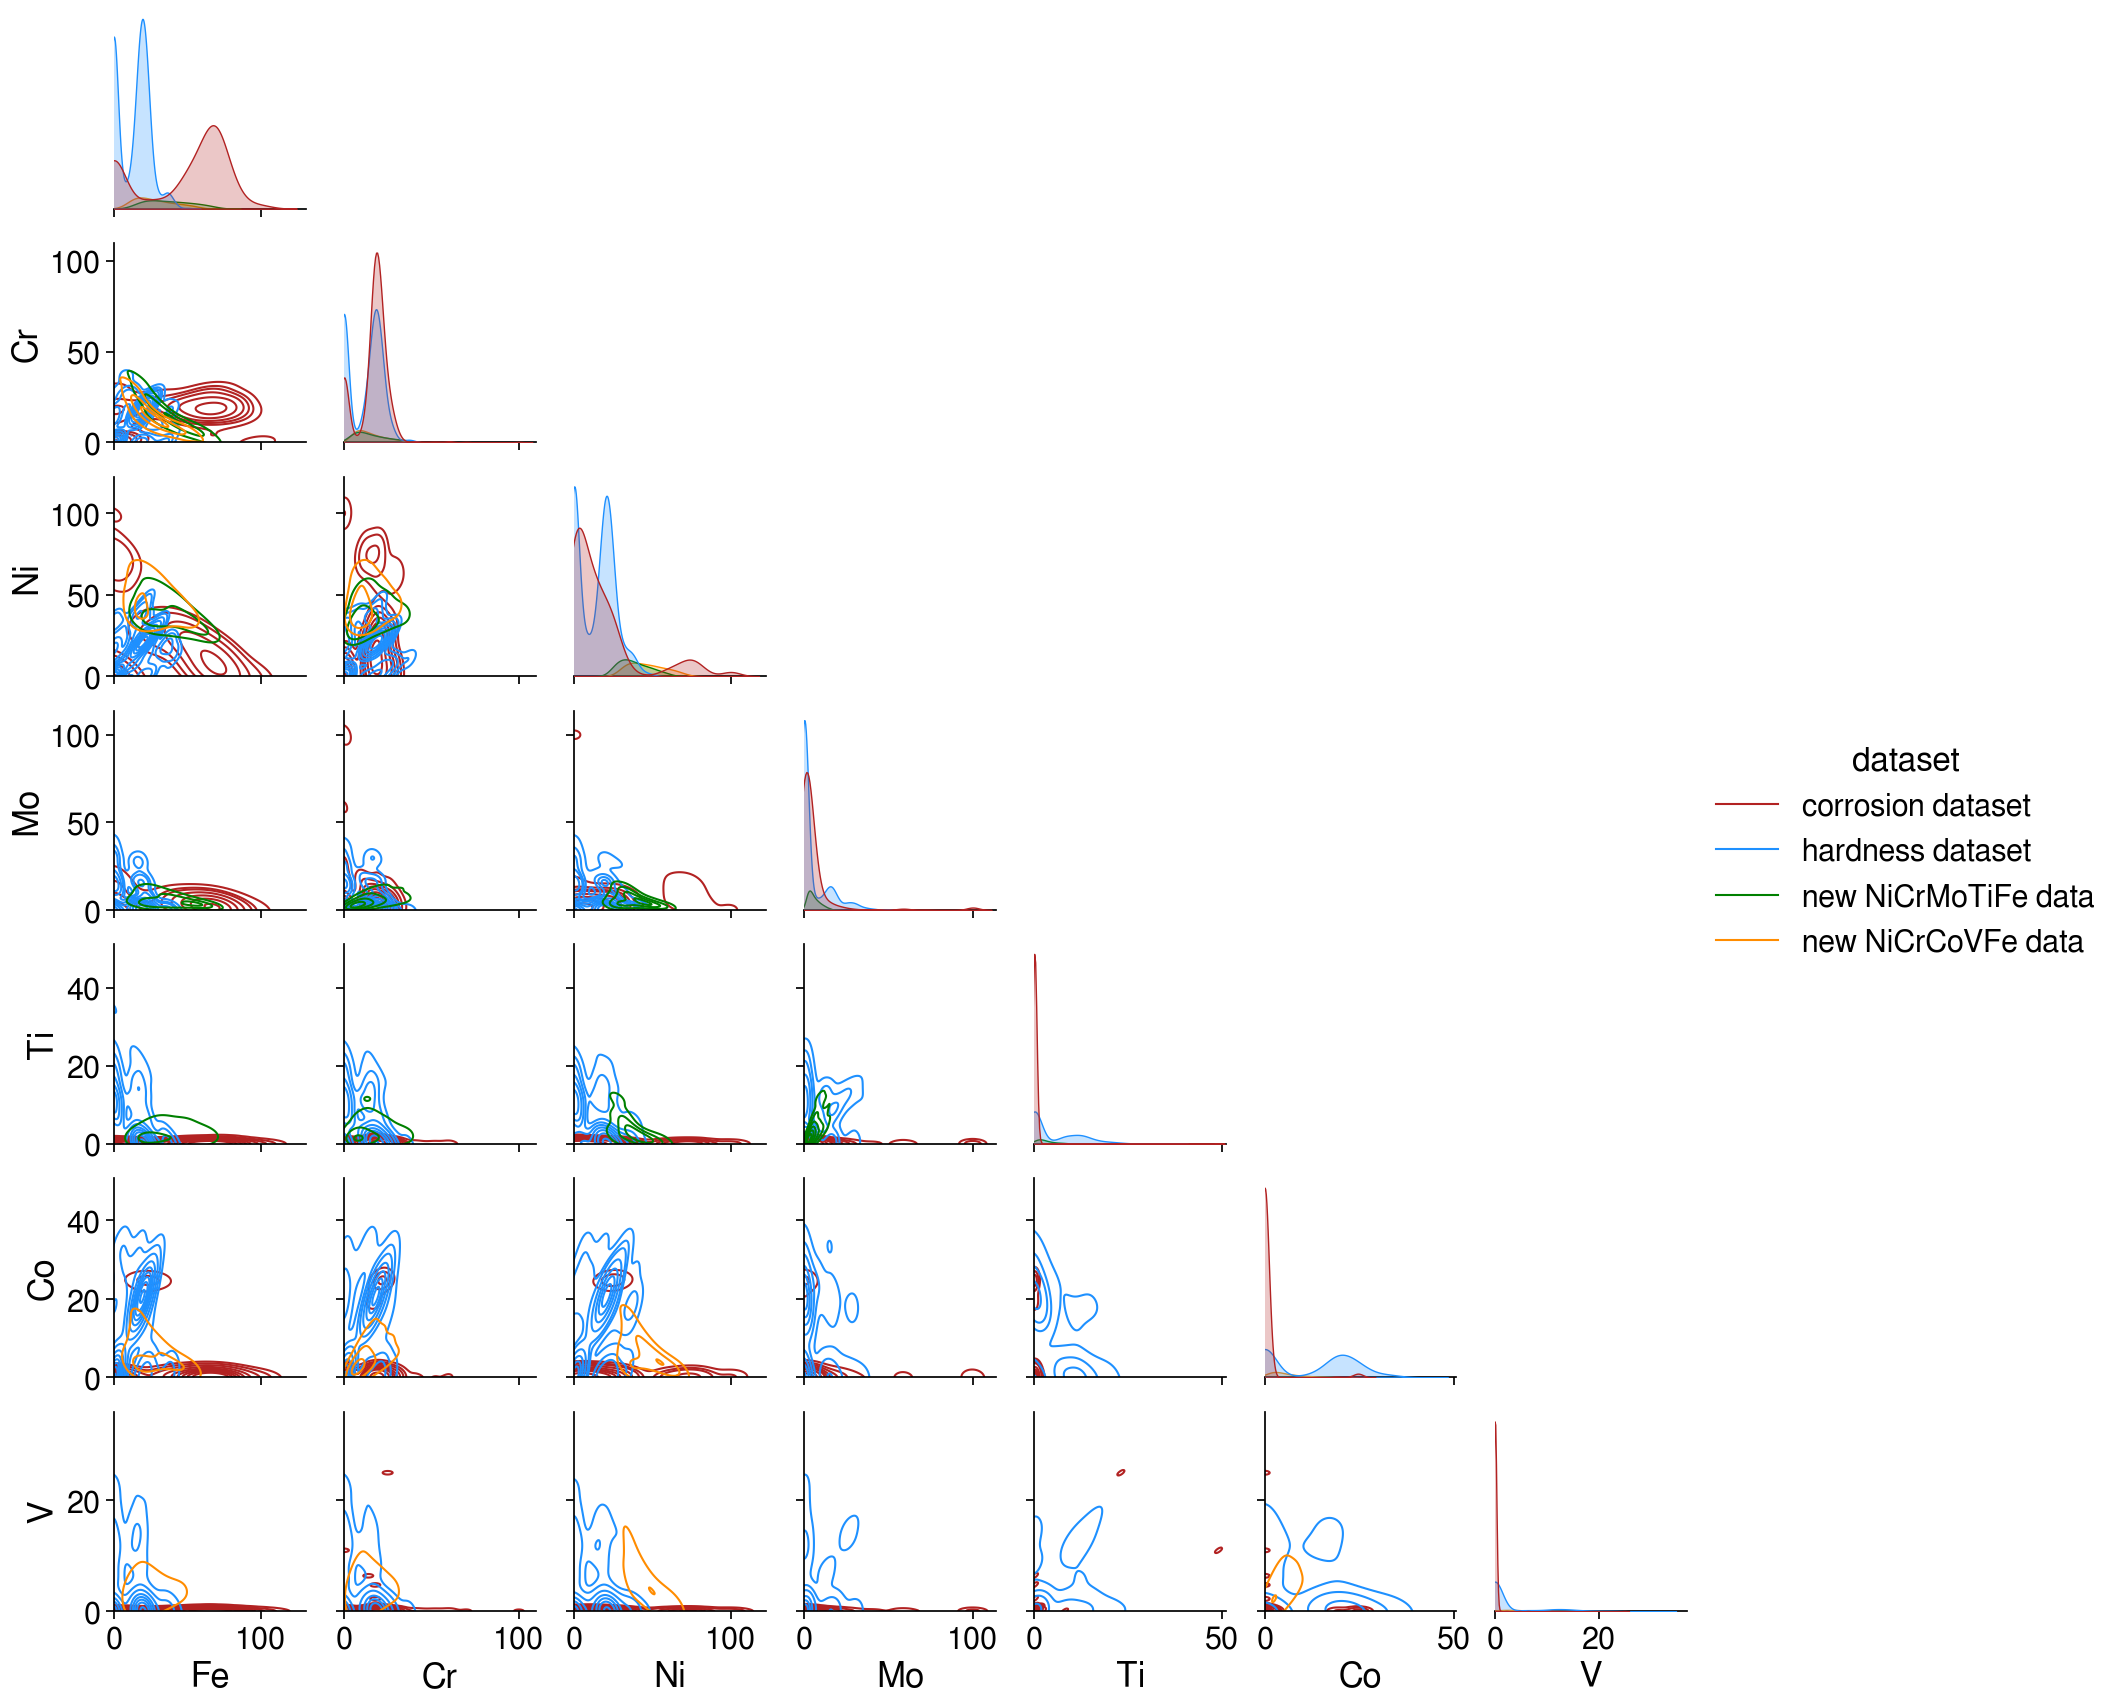

In [169]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_compo_conc_new, vars=['Fe', 'Cr', 'Ni', 'Mo', 'Ti', 'Co', 'V'],
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0),
      ax.set_ylim(bottom=0),
      ax.xaxis.label.set_size(25),
      ax.yaxis.label.set_size(25)]
     for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_compo_section_literature+new.pdf', bbox_inches='tight')

# Show the plots
plt.show()

composition + engineered feature space


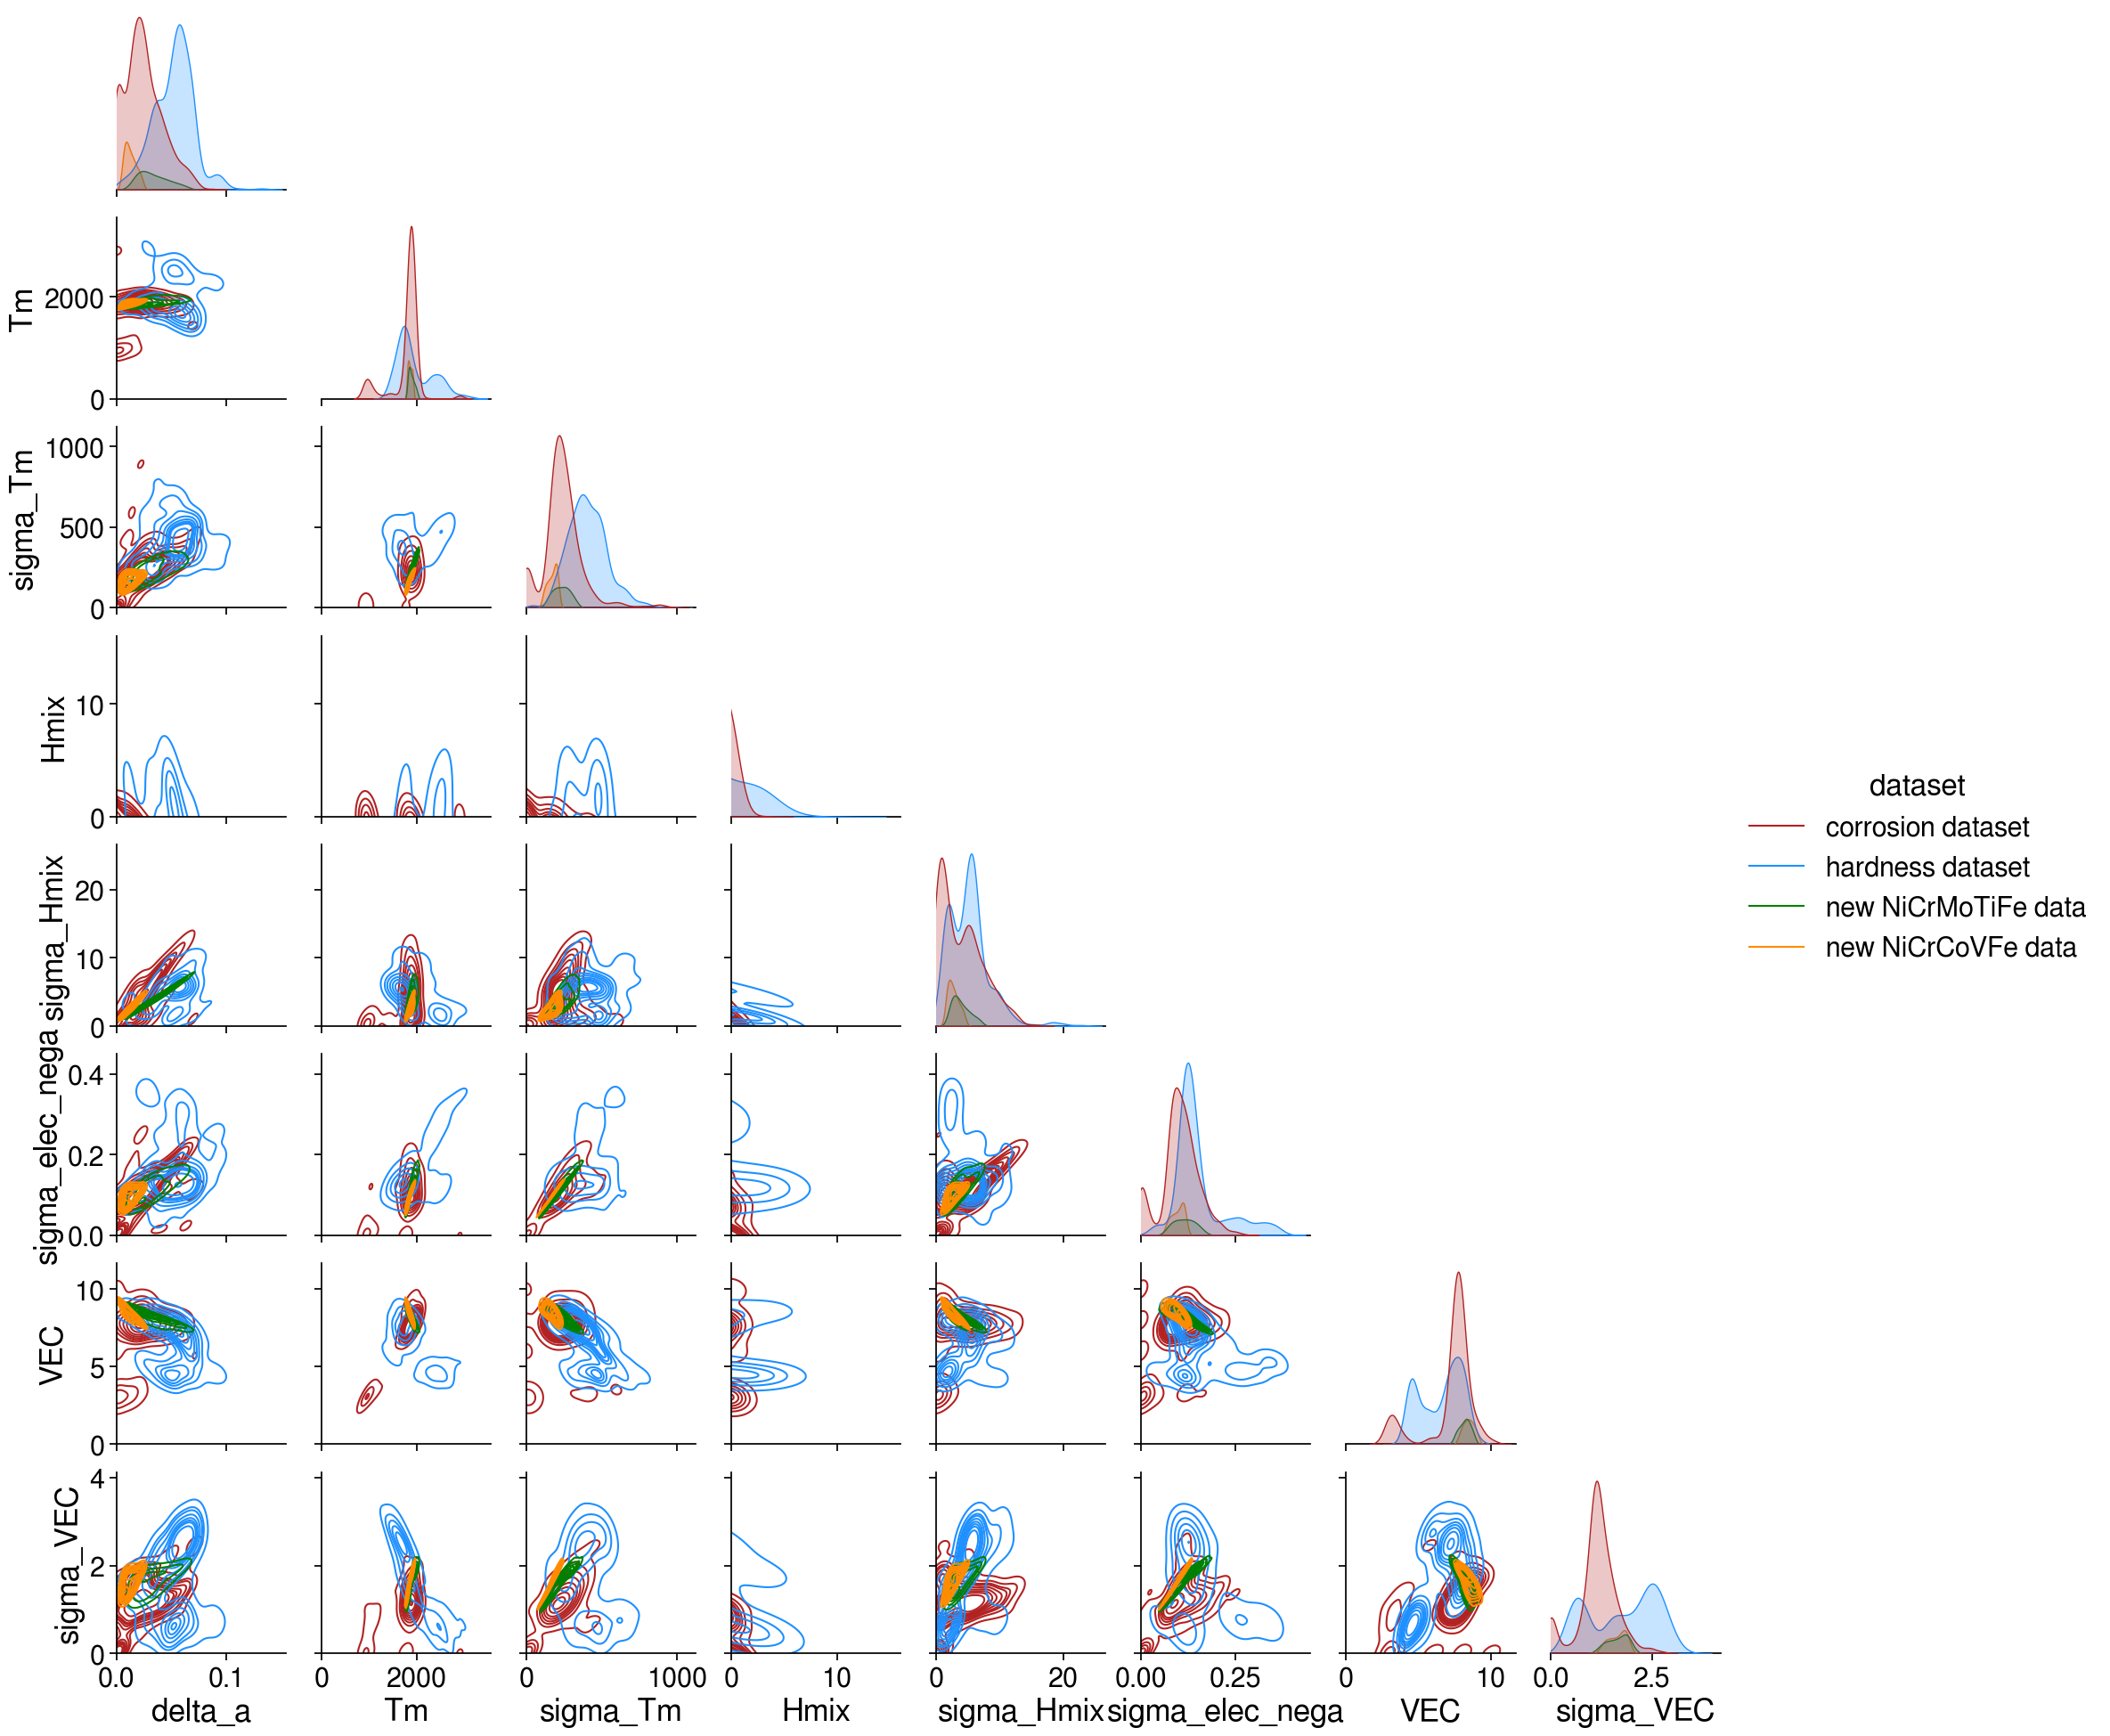

In [170]:
sns.set_context("notebook", font_scale=2)

# Define color palette for the pairplot
palette = ["firebrick", "dodgerblue", "green", "darkorange"]

# Create pairplot with KDE for all data
grid_kde = sns.pairplot(df_compo_specific_features_conc_new, vars=specific_features_sel_column,
                        hue="dataset", kind="kde", corner=True, palette=palette)

# Adjust x and y limits using list comprehension
_ = [[ax.set_xlim(left=0),
      ax.set_ylim(bottom=0),
      ax.xaxis.label.set_size(25),
      ax.yaxis.label.set_size(25)] for ax_row in grid_kde.axes for ax in ax_row if ax is not None]

plt.savefig('pairplot_feature_literature+new.pdf', bbox_inches='tight')

# Show the plots
plt.show()

## 1. Let's try PCA (Principal Component Analysis)


In [171]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


def perform_pca(df, dim_name1='Principle Component 1', dim_name2='Principle Component 2'):
    df_pca = df.copy()

    # Scale the data
    X_conc = MinMaxScaler().fit_transform(df_pca.drop(columns='dataset').values)

    y_conc = df_pca['dataset'].values

    # Perform PCA
    pca = PCA()
    X_conc_r = pca.fit_transform(X_conc)
    X_conc_r = X_conc_r[:, :2]

    # Add the PCA components to the dataframe
    df_pca[dim_name1] = X_conc_r[:, 0]
    df_pca[dim_name2] = X_conc_r[:, 1]

    # Print explained variance ratio
    print(
        f"Explained variance ratio (first two components): {pca.explained_variance_ratio_[0:2]}")

    return df_pca


def plot_data(df_pca, title='PCA',
              dim_name1='Principle Component 1', dim_name2='Principle Component 2',
              axis_lim=[-1.3, 1.3, -1.3, 1.3], threshold=0.1, levels=5):

    # Set up the plot
    colors = ["firebrick", "dodgerblue", "green", "darkorange"]

    # Create a joint plot with KDE contour
    g = sns.jointplot(data=df_pca, x=dim_name1, y=dim_name2,
                      hue='dataset', palette=colors, alpha=0.4)
    g.plot_joint(sns.kdeplot, zorder=0, palette=colors,
                 levels=levels, linewidths=1, alpha=0.75, thresh=threshold)

    # Customize the plot
    g.ax_joint.grid(linewidth=0.1)
    g.ax_joint.set_xlabel(dim_name1, fontsize=15)
    g.ax_joint.set_ylabel(dim_name2, fontsize=15)
    g.ax_joint.tick_params(labelsize=15)
    # g.ax_joint.set_aspect('equal', 'box')
    g.ax_joint.set_xlim(axis_lim[0], axis_lim[1])
    g.ax_joint.set_ylim(axis_lim[2], axis_lim[3])
    # g.ax_joint.set_title(title, fontsize=20, y=1.5)
    g.ax_joint.legend(loc='upper right', fontsize=22, bbox_to_anchor=(2.5, 1))

    # Set the same limits for the marginal plots
    g.ax_marg_x.set_xlim(axis_lim[0], axis_lim[1])
    g.ax_marg_y.set_ylim(axis_lim[2], axis_lim[3])

    # Save and show the plot
    plt.savefig(title + '.pdf', bbox_inches='tight')
    plt.show()


Explained variance ratio (first two components): [0.24339372 0.18287113]
Explained variance ratio (first two components): [0.23460085 0.19482752]


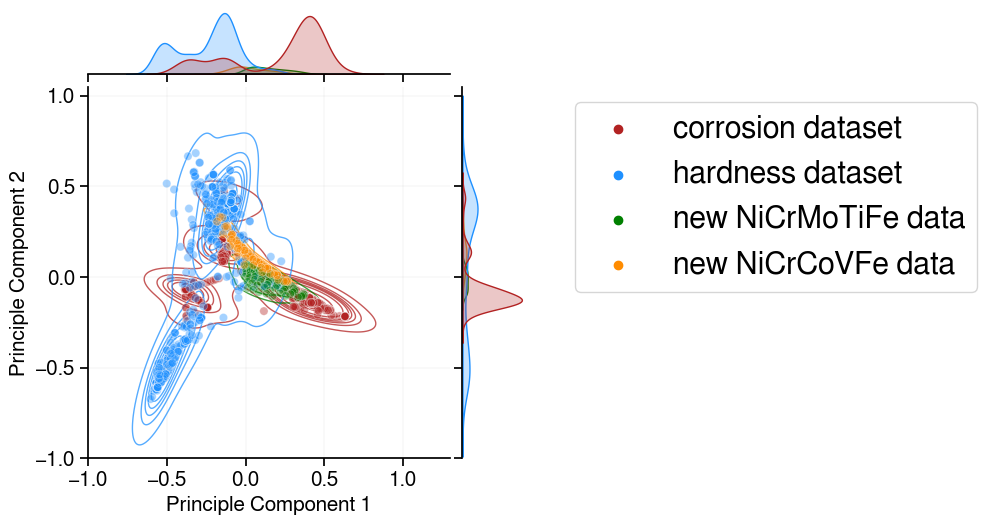

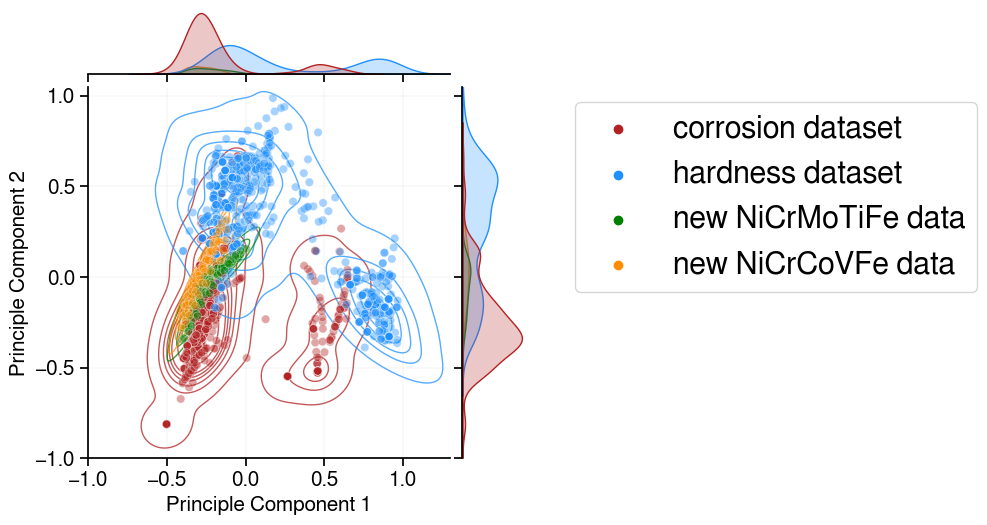

In [172]:
# Perform PCA on df_compo_conc_new
df_compo_conc_new_pca = perform_pca(
    df_compo_conc_new, dim_name1='Principle Component 1', dim_name2='Principle Component 2')

# Perform PCA on df_compo_specific_features_conc_new
df_compo_specific_features_conc_new_pca = perform_pca(df_compo_specific_features_conc_new,
                                                      dim_name1='Principle Component 1',
                                                      dim_name2='Principle Component 2')

# Plot data for df_compo_conc_new_pca
plot_data(df_compo_conc_new_pca, title='PCA 2D_Compositional Space',
          dim_name1='Principle Component 1', dim_name2='Principle Component 2',
          axis_lim=[-1, 1.3, -1, 1.05], threshold=0.02, levels=8)

# Plot data for df_compo_specific_features_conc_new_pca
plot_data(df_compo_specific_features_conc_new_pca, title='PCA 2D_Compositional and Engineered Feature Space',
          dim_name1='Principle Component 1', dim_name2='Principle Component 2',
          axis_lim=[-1, 1.3, -1, 1.05], threshold=0.02, levels=8)

## 2. Let's try UMAP (Uniform Manifold Approximation and Projection)


In [173]:
from umap import UMAP
from sklearn.covariance import EmpiricalCovariance
from scipy.linalg import inv
import numpy as np
import random

# np.random.seed(0)
# random.seed(0)


def perform_umap(df, n_neighbors=30, min_dist=0.6, n_components=2, metric='mahalanobis',
                 dim_name1='UMAP Component 1', dim_name2='UMAP Component 2', random_state=42):
    df_umap = df.copy()

    # Scale the data
    X_conc = MinMaxScaler().fit_transform(df_umap.drop(columns='dataset').values)
    y_conc = df_umap['dataset'].values

    # Calculate inverse covariance matrix
    cov = EmpiricalCovariance().fit(X_conc)
    inv_cov_matrix = inv(cov.covariance_)

    # Perform UMAP
    umap = UMAP(n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                metric=metric,
                metric_kwds={'VI': inv_cov_matrix},
                random_state=random_state)
    X_conc_r = umap.fit_transform(X_conc)

    # Add the UMAP components to the dataframe
    df_umap[dim_name1] = X_conc_r[:, 0]
    df_umap[dim_name2] = X_conc_r[:, 1]

    return df_umap

In [190]:
# # Perform UMAP on df_compo_conc_new (composition only)
# df_compo_conc_new_umap = perform_umap(df_compo_conc_new,
#                                       n_neighbors=20, min_dist=0.5, n_components=2, metric='mahalanobis',
#                                       dim_name1='UMAP Component 1', dim_name2='UMAP Component 2',
#                                       random_state=42)

# # Plot data for df_compo_conc_new_umap
# plot_data(df_compo_conc_new_umap, title='UMAP 2D_Compositional Space',
#           dim_name1='UMAP Component 1', dim_name2='UMAP Component 2',
#           axis_lim=[-100, 100, -50, 50], threshold=0.001, levels=30)

In [191]:
# Perform UMAP on df_compo_specific_features_conc_new
df_compo_specific_features_conc_new_umap = perform_umap(df_compo_specific_features_conc_new,
                                                        n_neighbors=20, min_dist=0.5, n_components=2, metric='mahalanobis',
                                                        dim_name1='UMAP Component 1', dim_name2='UMAP Component 2',
                                                        random_state=42)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset,UMAP Component 1,UMAP Component 2
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion dataset,3.465788,-0.9937


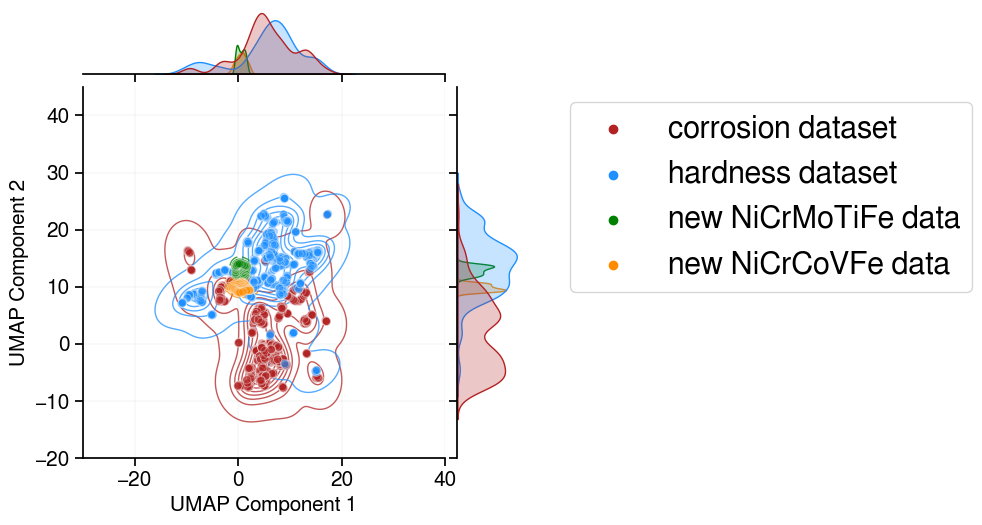

In [204]:
display(df_compo_specific_features_conc_new_umap.head(1))

# Plot data for df_compo_specific_features_conc_new_umap
plot_data(df_compo_specific_features_conc_new_umap, title='UMAP 2D_Compositional and Engineered Feature Space',
          dim_name1='UMAP Component 1', dim_name2='UMAP Component 2',
          axis_lim=[-30, 40, -20, 45], threshold=0.001, levels=30)

## 3. Let's try to use the local Mahalanobis distance

### Multivariate analysis to examine the local (Mahalanobis) Distance from new data to existing datasets


In [193]:
import scipy.stats as stats
from scipy.stats import chi2
import numpy as np


here decide to use composition + engineered feature space for piror Mahalanobis distance analysis


In [194]:
df_C_umap = df_compo_specific_features_conc_new_umap[
    df_compo_specific_features_conc_new_umap['dataset'] == 'corrosion dataset']
df_H_umap = df_compo_specific_features_conc_new_umap[
    df_compo_specific_features_conc_new_umap['dataset'] == 'hardness dataset']
df_new_FeCrNiMoTi_umap = df_compo_specific_features_conc_new_umap[
    df_compo_specific_features_conc_new_umap['dataset'] == 'new NiCrMoTiFe data']
df_new_FeCrNiCoV_umap = df_compo_specific_features_conc_new_umap[
    df_compo_specific_features_conc_new_umap['dataset'] == 'new NiCrCoVFe data']


# prepare the df for calculating Mahalanobis distance (cannot have string in df)
display(df_C_umap.iloc[[0, -1]], df_C_umap.shape,
        df_H_umap.iloc[[0, -1]], df_H_umap.shape,
        df_new_FeCrNiMoTi_umap.iloc[[0, -1]], df_new_FeCrNiMoTi_umap.shape,
        df_new_FeCrNiCoV_umap.iloc[[0, -1]], df_new_FeCrNiCoV_umap.shape)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset,UMAP Component 1,UMAP Component 2
0,69.77,18.00,10.0,0.0,0.0,0.0,0.0,0.03,1.00,1.00,...,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,corrosion dataset,3.465788,-0.993700
711,0.16,0.23,0.0,0.0,0.0,0.0,0.0,0.00,0.08,0.02,...,936.061425,54.273452,-0.350818,0.773645,0.049889,2.982996,0.264460,corrosion dataset,5.165352,-1.173077


(712, 31)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset,UMAP Component 1,UMAP Component 2
712,19.92,18.54,20.93,0.00,0.0,0.0,0.0,0.0,0.0,19.59,...,1801.194406,214.312458,-4.1597,2.197442,0.138357,8.000092,1.414148,hardness dataset,-7.189182,7.366351
1391,20.17,0.00,42.40,6.93,0.0,0.0,0.0,0.0,0.0,0.00,...,1852.264411,257.734769,-6.8264,3.890390,0.103641,8.659625,1.614745,hardness dataset,1.903072,8.474424


(680, 31)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset,UMAP Component 1,UMAP Component 2
1392,14.316994,35.210247,45.453038,4.138939,0.0,0.0,0.0,0.0,0.0,0.0,...,1943.689937,257.662231,-6.600671,2.725195,0.129477,8.019565,1.882783,new NiCrMoTiFe data,1.001467,11.499764
1460,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.0,0.0,0.0,...,1844.869218,192.175144,-5.701689,4.064609,0.098628,8.101491,1.410874,new NiCrMoTiFe data,0.293396,14.048017


(69, 31)

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,dataset,UMAP Component 1,UMAP Component 2
1461,10.271486,31.290494,51.985556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1898.775789,210.082957,-6.271299,2.111357,0.115683,8.311398,1.854884,new NiCrCoVFe data,0.794238,10.855304
1529,51.347188,5.827793,31.584854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1841.240483,148.982134,-5.437576,2.782294,0.086038,8.238582,1.496411,new NiCrCoVFe data,0.908602,9.085214


(69, 31)

preparing the existing datasets (literature+new)


In [195]:
# Merge existing and new datasets, replacing missing values with 0
df_C_new_FeCrNiMoTi = pd.concat(
    [df_C_umap, df_new_FeCrNiMoTi_umap], ignore_index=True).fillna(0)
df_C_new_FeCrNiCoV = pd.concat(
    [df_C_umap, df_new_FeCrNiCoV_umap], ignore_index=True).fillna(0)
df_H_new_FeCrNiMoTi = pd.concat(
    [df_H_umap, df_new_FeCrNiMoTi_umap], ignore_index=True).fillna(0)
df_H_new_FeCrNiCoV = pd.concat(
    [df_H_umap, df_new_FeCrNiCoV_umap], ignore_index=True).fillna(0)


def process_df_Mahal(df):
    df_num = df.loc[:, ~df.columns.isin(
        ['dataset', 'UMAP Component 1', 'UMAP Component 2'])]
    df_label = df[['dataset', 'UMAP Component 1', 'UMAP Component 2']]

    # Detect zero columns using 'all' method after comparing with 0
    zero_columns = (df_num == 0).all()

    # Print the names of the columns containing only zeros with context
    print("Columns only containing zeros:",
          zero_columns[zero_columns].index.tolist())

    # Drop the zero columns using boolean indexing
    df_num = df_num.loc[:, ~zero_columns]

    return df_num, df_label


# Process each dataframe and separate numerical and label data
df_C_new_FeCrNiMoTi_num, df_C_new_FeCrNiMoTi_label = process_df_Mahal(
    df_C_new_FeCrNiMoTi)
df_C_new_FeCrNiCoV_num, df_C_new_FeCrNiCoV_label = process_df_Mahal(
    df_C_new_FeCrNiCoV)
df_H_new_FeCrNiMoTi_num, df_H_new_FeCrNiMoTi_label = process_df_Mahal(
    df_H_new_FeCrNiMoTi)
df_H_new_FeCrNiCoV_num, df_H_new_FeCrNiCoV_label = process_df_Mahal(
    df_H_new_FeCrNiCoV)

display(df_C_new_FeCrNiMoTi_num.iloc[[0, -1]],
        df_C_new_FeCrNiMoTi_label.iloc[[0, -1]])

Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['Zr', 'Hf']
Columns only containing zeros: ['N', 'Mg']
Columns only containing zeros: ['N', 'Mg']


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Mg,Y,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.039801,1844.869218,192.175144,-5.701689,4.064609,0.098628,8.101491,1.410874


,dataset,UMAP Component 1,UMAP Component 2
0,corrosion dataset,3.465788,-0.993700
780,new NiCrMoTiFe data,0.293396,14.048017


calculate the Mahalanobis distance


In [196]:
df_C_new_FeCrNiMoTi_Mahl = df_C_new_FeCrNiMoTi_num.copy()
df_C_new_FeCrNiCoV_Mahl = df_C_new_FeCrNiCoV_num.copy()
df_H_new_FeCrNiMoTi_Mahl = df_H_new_FeCrNiMoTi_num.copy()
df_H_new_FeCrNiCoV_Mahl = df_H_new_FeCrNiCoV_num.copy()

# Function to calculate the Mahalanobis distance of each point to the "center" of the dataset


def calculateMahalanobis(y=None, data=None, cov=None):
    # Compute the Mahalanobis Distance between each row of y and the data
    # y    : matrix of data with, say, p columns (new observation).
    # data : ndarray of the distribution (existing data), from which Mahalanobis distance of each observation of y is to be computed.
    # cov  : covariance matrix (p x p) of the distribution(existing data). If None, will be computed from data.

    y_mu = y - np.mean(data, axis=0)
    if cov is None:
        cov = np.cov(data.values.T)
        cov += np.eye(cov.shape[0]) * 1e-6
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)

    # print(y_mu.isna().sum().sum())  # check if y_mu has any NaN
    # print(inv_covmat)  # see the inverse covariance matrix
    return mahal.diagonal()


# y: new observation, data: existing data from which Mahalanobis distance is to be computed.
df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(
    y=df_C_new_FeCrNiMoTi_Mahl, data=df_C_new_FeCrNiMoTi_num)
df_C_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(
    y=df_C_new_FeCrNiCoV_Mahl, data=df_C_new_FeCrNiCoV_num)
df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'] = calculateMahalanobis(
    y=df_H_new_FeCrNiMoTi_Mahl, data=df_H_new_FeCrNiMoTi_num)
df_H_new_FeCrNiCoV_Mahl['Mahalanobis'] = calculateMahalanobis(
    y=df_H_new_FeCrNiCoV_Mahl, data=df_H_new_FeCrNiCoV_num)

display(df_C_new_FeCrNiMoTi_Mahl.head(1))
display(df_C_new_FeCrNiCoV_Mahl.head(1))
display(df_H_new_FeCrNiMoTi_Mahl.head(1))
display(df_H_new_FeCrNiCoV_Mahl.head(1))

,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Y,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,4.557613


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Y,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,Mahalanobis
0,69.77,18.0,10.0,0.0,0.0,0.0,0.0,0.03,1.0,1.0,...,0.0,0.019485,1869.874935,173.330067,-4.484751,4.974488,0.083927,7.719083,1.188494,4.470198


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,...,0.0,0.032693,1801.194406,214.312458,-4.1597,2.197442,0.138357,8.000092,1.414148,9.258763


,Fe,Cr,Ni,Mo,W,Nb,C,Si,Mn,Cu,...,Hf,delta_a,Tm,sigma_Tm,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,Mahalanobis
0,19.92,18.54,20.93,0.0,0.0,0.0,0.0,0.0,19.59,0.0,...,0.0,0.032693,1801.194406,214.312458,-4.1597,2.197442,0.138357,8.000092,1.414148,9.317482


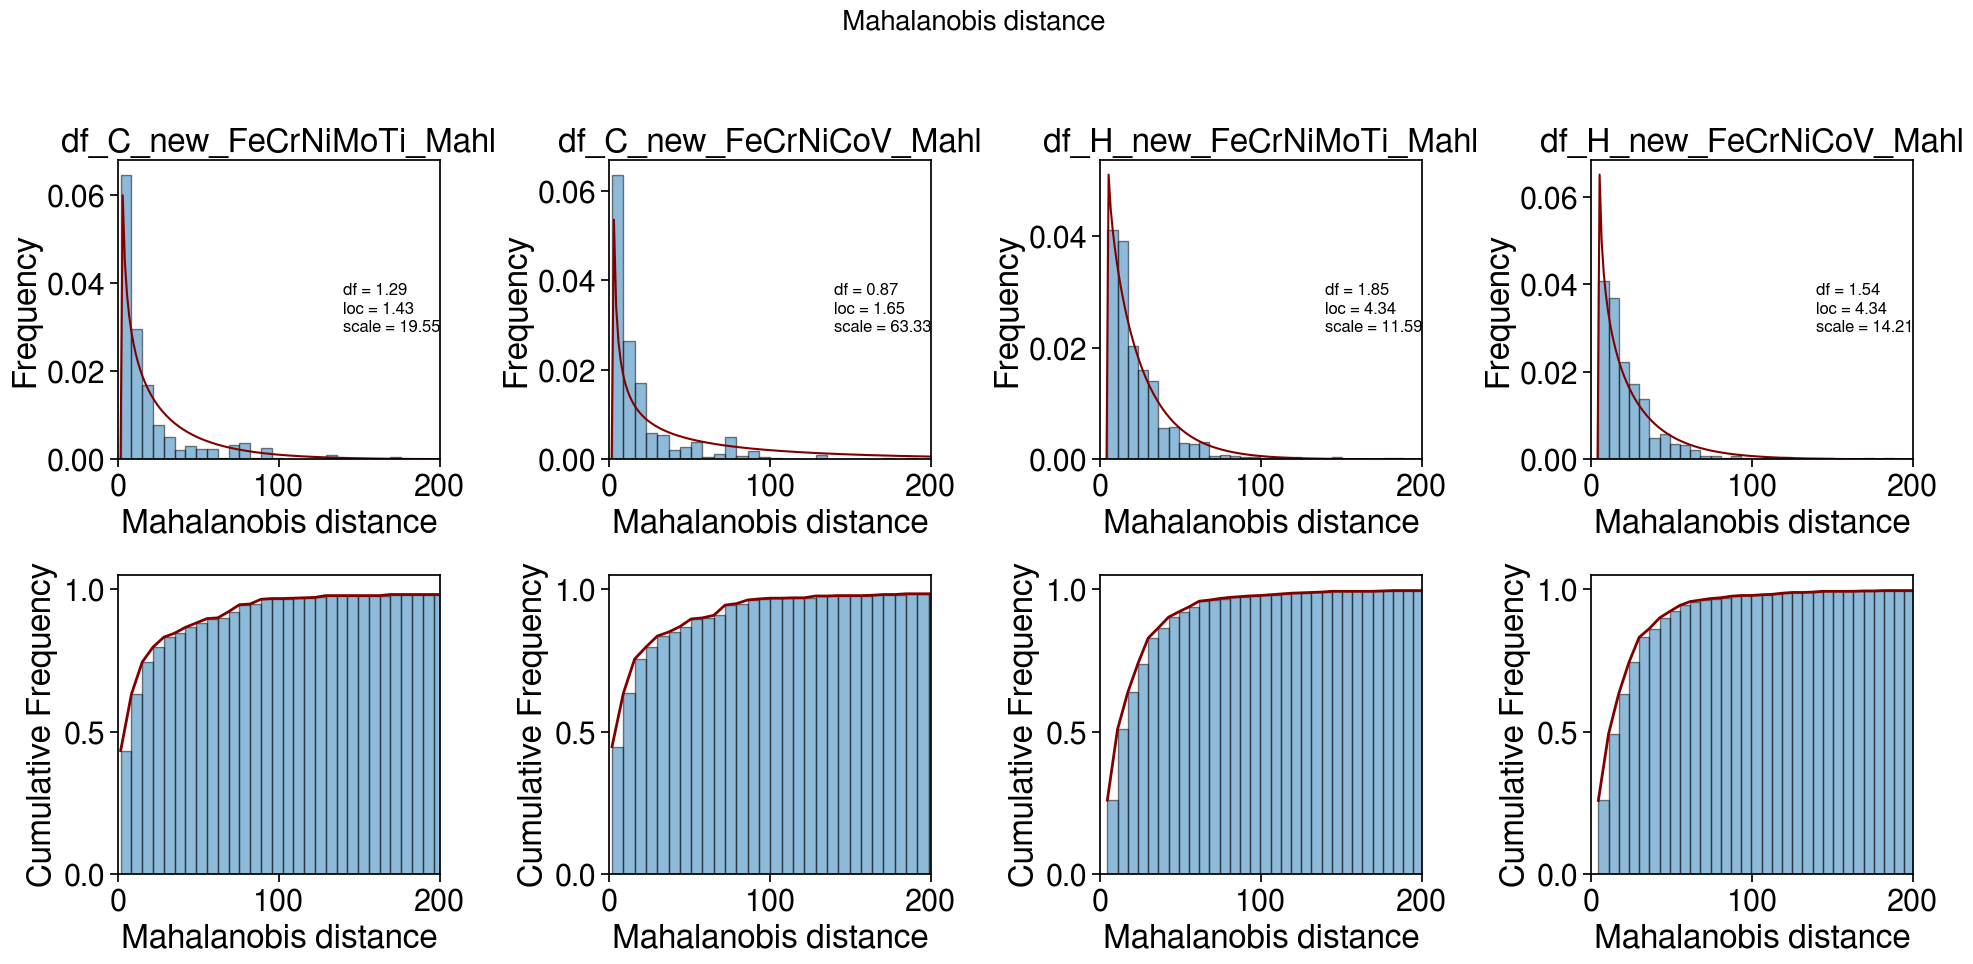

In [197]:
# Define dataframes in a list
dfs = [df_C_new_FeCrNiMoTi_Mahl, df_C_new_FeCrNiCoV_Mahl,
       df_H_new_FeCrNiMoTi_Mahl, df_H_new_FeCrNiCoV_Mahl]
titles = ['df_C_new_FeCrNiMoTi_Mahl', 'df_C_new_FeCrNiCoV_Mahl',
          'df_H_new_FeCrNiMoTi_Mahl', 'df_H_new_FeCrNiCoV_Mahl']

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Mahalanobis distance', fontsize=20)

# Iterate through dataframes
for i, df in enumerate(dfs):
    # Plot histogram
    axs[0, i].hist(df['Mahalanobis'], bins=100,
                   edgecolor='black', alpha=0.5, density=True)
    axs[0, i].set_xlabel('Mahalanobis distance')
    axs[0, i].set_ylabel('Frequency')
    axs[0, i].set_xlim(0, 200)
    axs[0, i].set_title(titles[i])

    # Fit a chi-squared distribution to the data
    df_param, loc, scale = stats.chi2.fit(df['Mahalanobis'])
    # Plot the fitted distribution over the histogram
    x_chi2 = np.linspace(0, np.amax(df['Mahalanobis']), 500)
    pdf_chi2 = stats.chi2.pdf(x_chi2, df=df_param, loc=loc, scale=scale)
    axs[0, i].plot(x_chi2, pdf_chi2, 'maroon')
    # Add the fitted values to the plot
    axs[0, i].text(0.7, 0.5, f"df = {df_param:.2f}\nloc = {loc:.2f}\nscale = {scale:.2f}",
                   transform=axs[0, i].transAxes, ha='left', va='center', fontsize=12)

    # Plot CDF
    counts, bins, patches = axs[1, i].hist(
        df['Mahalanobis'], bins=100, edgecolor='black', alpha=0.5, cumulative=True, density=True)
    axs[1, i].plot(bins[:-1], counts, 'maroon', lw=2)
    axs[1, i].set_xlim(0, 200)
    axs[1, i].set_xlabel('Mahalanobis distance')
    axs[1, i].set_ylabel('Cumulative Frequency')

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping
plt.show()

Use chi2 statistics to get a more presentable number: p-value based on chi2 distribution with degree of freedom = 2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4381501/


,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,Mn,...,Hmix,sigma_Hmix,sigma_elec_nega,VEC,sigma_VEC,Mahalanobis,p value,dataset,UMAP Component 1,UMAP Component 2
0,69.770000,18.000000,10.000000,0.000000,0.0,0.0,0.0,0.03,1.0,1.0,...,-4.484751,4.974488,0.083927,7.719083,1.188494,4.557613,0.102406,corrosion dataset,3.465788,-0.993700
780,63.370312,5.076982,23.439965,4.034033,0.0,0.0,0.0,0.00,0.0,0.0,...,-5.701689,4.064609,0.098628,8.101491,1.410874,14.750302,0.000627,new NiCrMoTiFe data,0.293396,14.048017


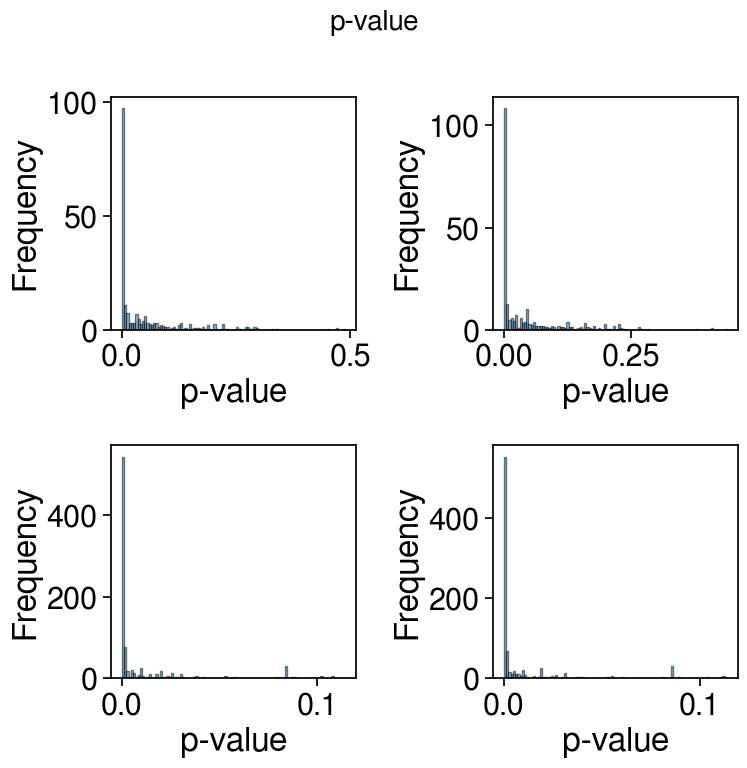

In [198]:
# calculate p-value for each mahalanobis distance using
df_C_new_FeCrNiMoTi_Mahl['p value'] = 1 - \
    chi2.cdf(df_C_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_C_new_FeCrNiCoV_Mahl['p value'] = 1 - \
    chi2.cdf(df_C_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiMoTi_Mahl['p value'] = 1 - \
    chi2.cdf(df_H_new_FeCrNiMoTi_Mahl['Mahalanobis'], 2)
df_H_new_FeCrNiCoV_Mahl['p value'] = 1 - \
    chi2.cdf(df_H_new_FeCrNiCoV_Mahl['Mahalanobis'], 2)

# re-attach the labels
df_C_new_FeCrNiMoTi_Mahl_label = pd.concat(
    [df_C_new_FeCrNiMoTi_Mahl,  df_C_new_FeCrNiMoTi_label], axis=1)
df_C_new_FeCrNiCoV_Mahl_label = pd.concat(
    [df_C_new_FeCrNiCoV_Mahl,  df_C_new_FeCrNiCoV_label], axis=1)
df_H_new_FeCrNiMoTi_Mahl_label = pd.concat(
    [df_H_new_FeCrNiMoTi_Mahl,  df_H_new_FeCrNiMoTi_label], axis=1)
df_H_new_FeCrNiCoV_Mahl_label = pd.concat(
    [df_H_new_FeCrNiCoV_Mahl,  df_H_new_FeCrNiCoV_label], axis=1)

display(df_C_new_FeCrNiMoTi_Mahl_label.iloc[[0, -1]])

# plot the histogram of p-values for all the datasets
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('p-value', fontsize=20)
axs[0, 0].hist(df_C_new_FeCrNiMoTi_Mahl['p value'], bins=100,
               edgecolor='black', alpha=0.5, density=True)
axs[0, 0].set_xlabel('p-value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(df_C_new_FeCrNiCoV_Mahl['p value'], bins=100,
               edgecolor='black', alpha=0.5, density=True)
axs[0, 1].set_xlabel('p-value')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(df_H_new_FeCrNiMoTi_Mahl['p value'], bins=100,
               edgecolor='black', alpha=0.5, density=True)
axs[1, 0].set_xlabel('p-value')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(df_H_new_FeCrNiCoV_Mahl['p value'], bins=100,
               edgecolor='black', alpha=0.5, density=True)
axs[1, 1].set_xlabel('p-value')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

If we believe the p value from chi2 statistics can be a measure of "novelty" (smaller ones are more likely outliers), we plot it back to PCA 2D project and also PVD representation


map the chi2 pvalues to the PCA 2D projection: it seems the variation of p value is NOT monotonic on this 2D projection

I mainly highlighted the "new" dataset (you can still see the translucent "training" data points)


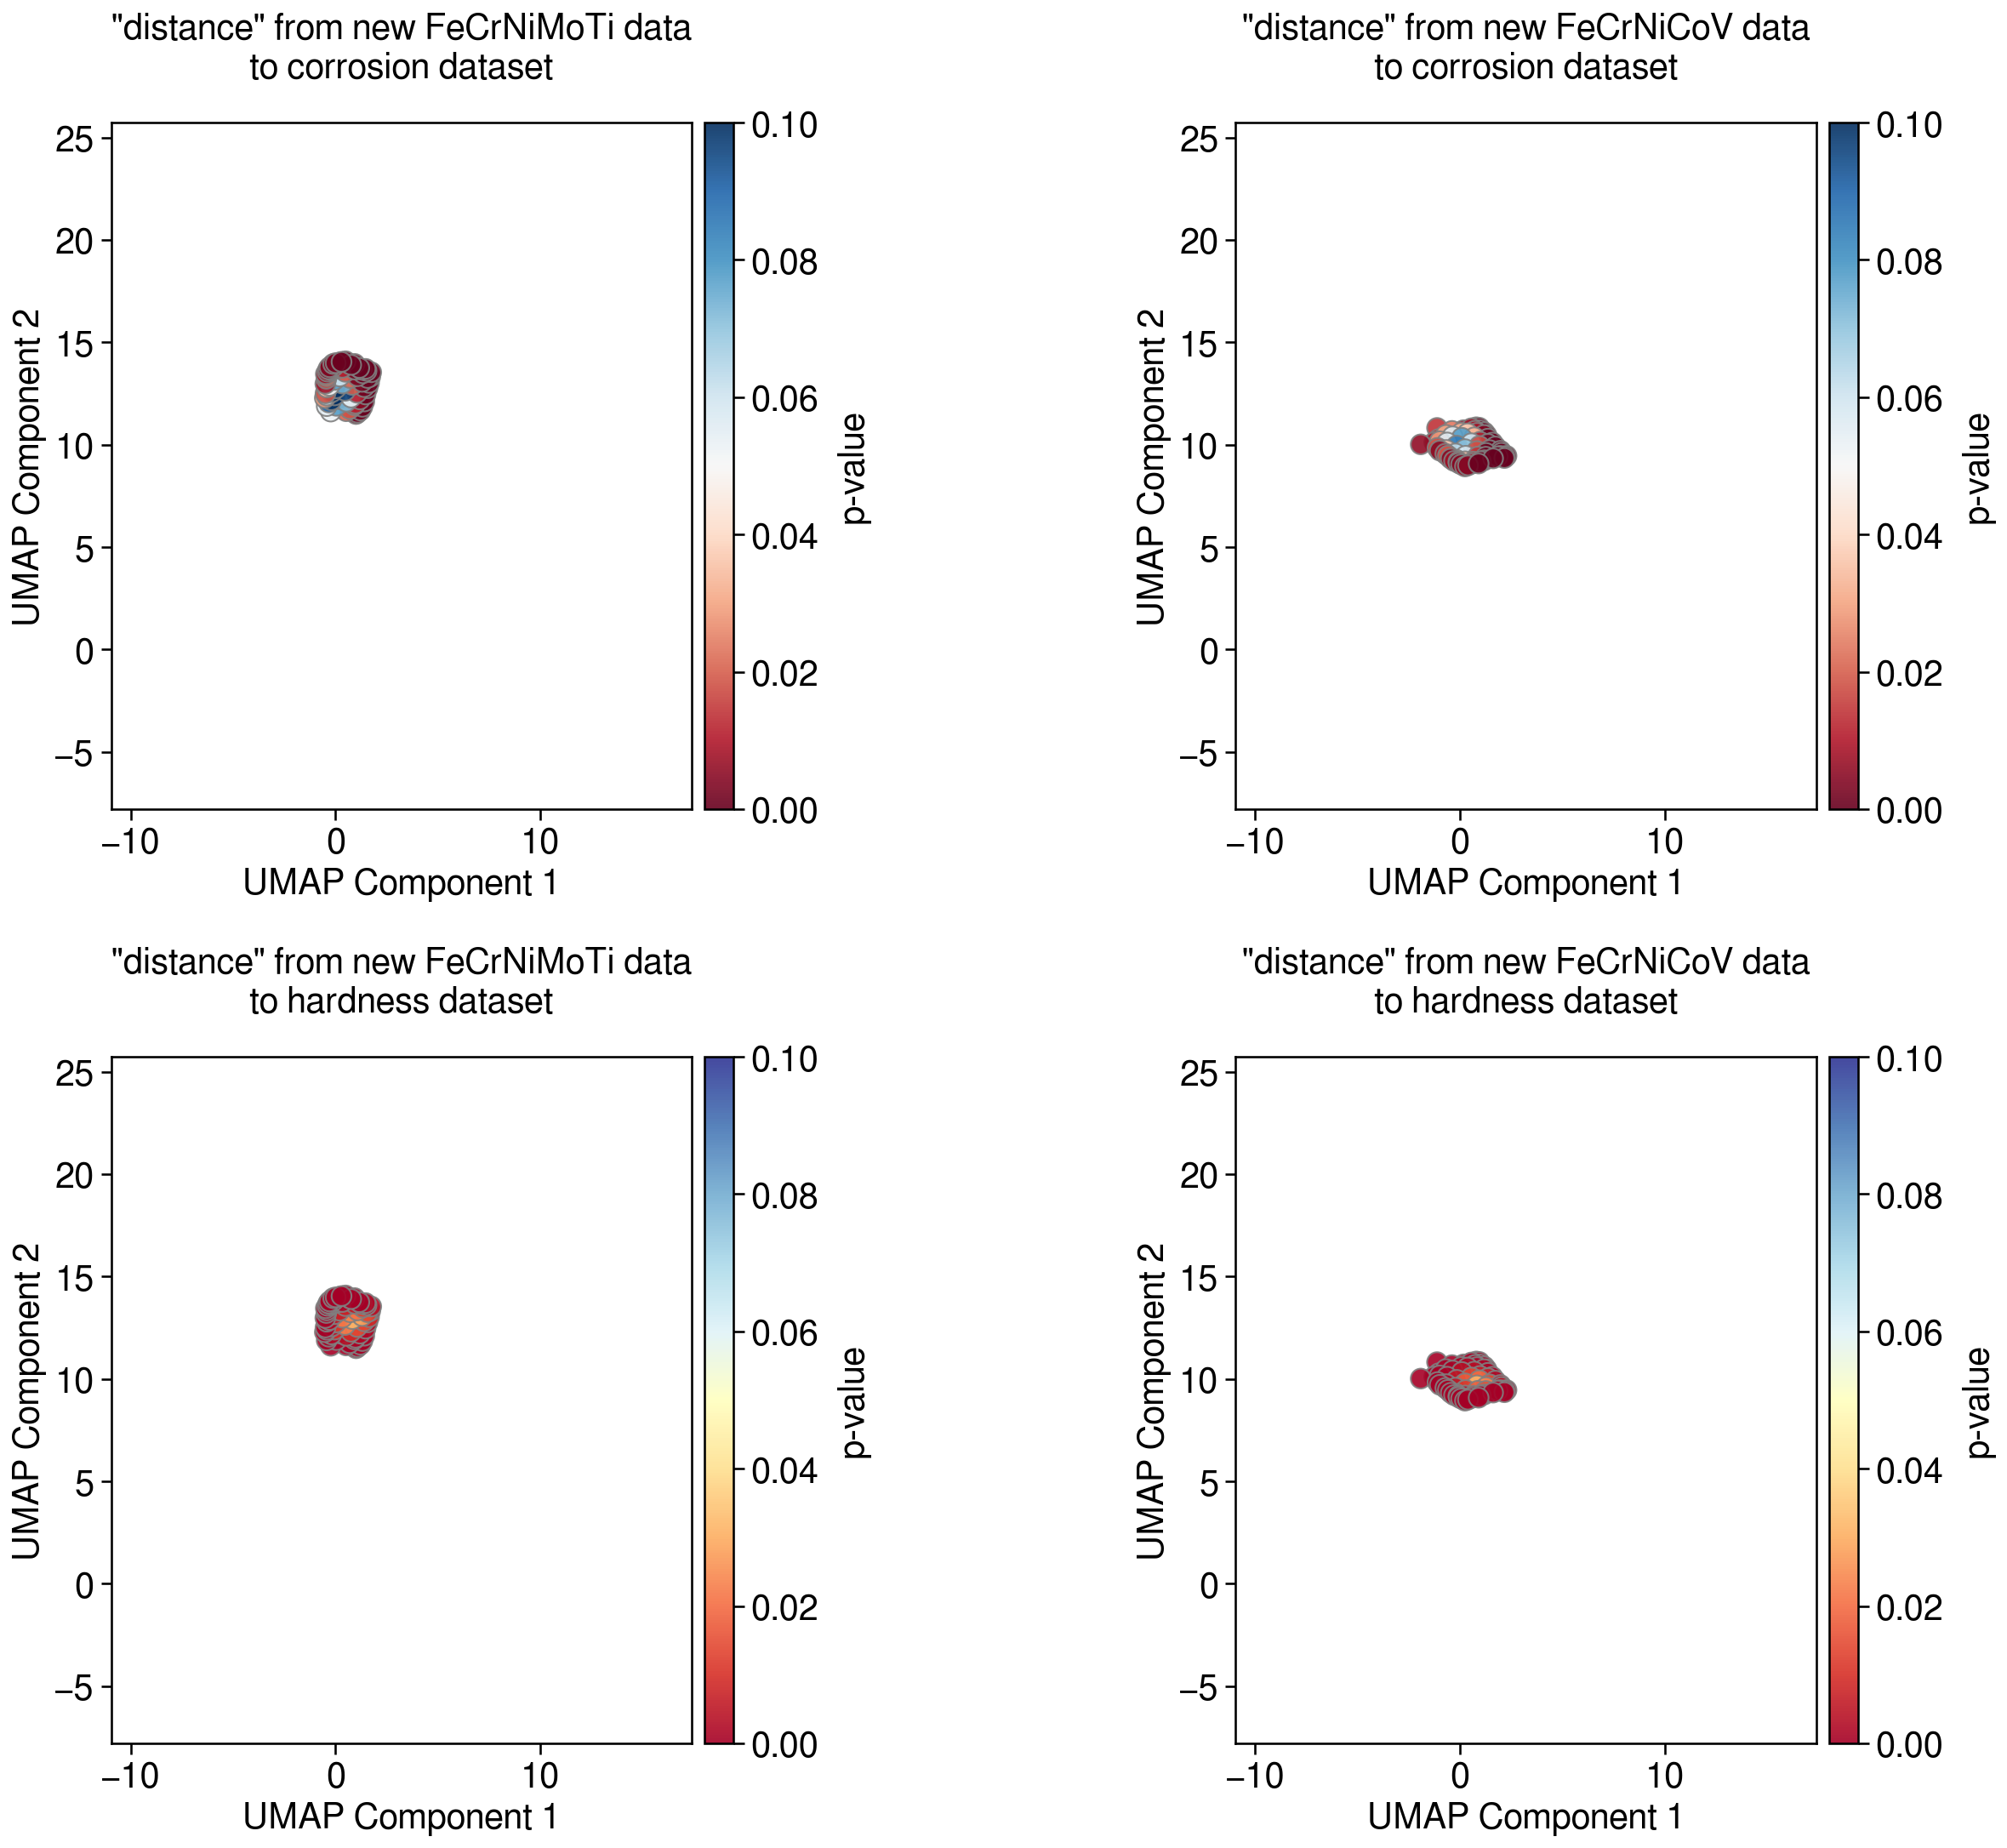

In [199]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def create_scatter(df, dataset_values, ax, cmap="RdBu", titlename="name?"):
    # Create separate dataframes for each dataset
    df_literature = df[df["dataset"] == dataset_values[0]]
    df_new = df[df["dataset"] == dataset_values[1]]

    # Create the scatter plots
    scatters = []
    for df, alpha in zip([df_literature, df_new], [0.2, 0.9]):
        scatter = ax.scatter(df["UMAP Component 1"], df["UMAP Component 2"], c=df["p value"], cmap=cmap, edgecolor="grey",
                             s=500, marker='.', alpha=alpha, vmin=0, vmax=0.1)
        scatters.append(scatter)

        ax.set_xlabel("UMAP Component 1", fontsize=20)
        ax.set_ylabel("UMAP Component 2", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        # set the subplot title to the dataset name
        ax.set_title(titlename, fontsize=20, y=1.05)
        # make equal aspect ratio
        ax.set_aspect('equal', 'box')

    return scatters


# create the subplots of 2x2
fig, ax = plt.subplots(2, 2, figsize=(18, 15), dpi=150)

datasets = [(df_C_new_FeCrNiMoTi_Mahl_label, ['corrosion data', 'new NiCrMoTiFe data'], "RdBu",
             '"distance" from new FeCrNiMoTi data\nto corrosion dataset'),
            (df_C_new_FeCrNiCoV_Mahl_label, ['corrosion data', 'new NiCrCoVFe data'], "RdBu",
             '"distance" from new FeCrNiCoV data\nto corrosion dataset'),
            (df_H_new_FeCrNiMoTi_Mahl_label, ['hardness data', 'new NiCrMoTiFe data'], "RdYlBu",
             '"distance" from new FeCrNiMoTi data\nto hardness dataset'),
            (df_H_new_FeCrNiCoV_Mahl_label, ['hardness data', 'new NiCrCoVFe data'], "RdYlBu",
             '"distance" from new FeCrNiCoV data\nto hardness dataset')]

# Get global min and max for UMAP components
xmin, xmax = min(df['UMAP Component 1'].min() for df, _, _, _ in datasets), max(
    df['UMAP Component 1'].max() for df, _, _, _ in datasets)
ymin, ymax = min(df['UMAP Component 2'].min() for df, _, _, _ in datasets), max(
    df['UMAP Component 2'].max() for df, _, _, _ in datasets)


for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i//2, i % 2]  # Get the current axis
    scatters = create_scatter(df, dataset_values, axi,
                              cmap=cmap, titlename=title)

    # Set the limits
    axi.set_xlim(xmin, xmax)
    axi.set_ylim(ymin, ymax)

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(axi)

    # Append axes for colorbar to the right of axi, with 5% width of axi
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(scatters[-1], cax=cax)
    cbar.set_label("p-value", size=20, labelpad=10)
    cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('UMAP 2D_Mahalanobis.png')
plt.show()

Now I will plot the p value on the representation of PVD wafer


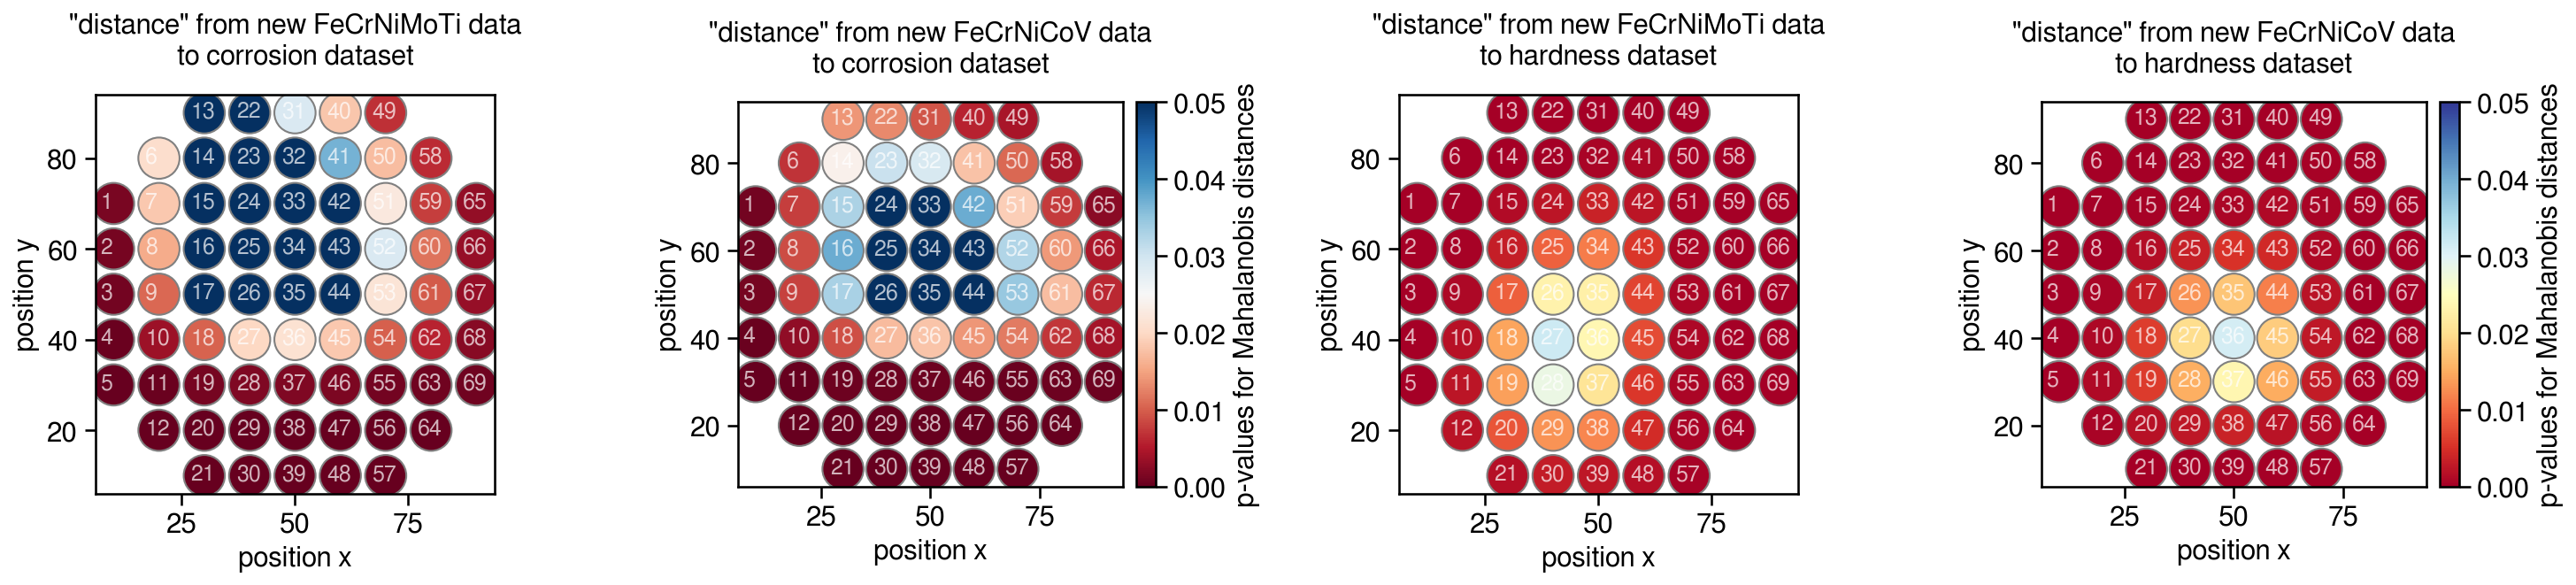

In [200]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')


def create_PVD_scatter(df, PVD_x_y, dataset_values, ax, cmap="RdBu", title=""):
    df_new = df[df["dataset"] == dataset_values[1]]
    scatter = ax.scatter(PVD_x_y["x"], PVD_x_y["y"], c=df_new["p value"], cmap=cmap, edgecolor="grey",
                         s=2000, marker='.', alpha=1, vmin=0, vmax=0.05)

    for i, txt in enumerate(PVD_x_y.index+1):
        ax.annotate(txt, (PVD_x_y["x"].iloc[i]-3, PVD_x_y["y"].iloc[i]-1),
                    color="white", alpha=0.7, fontsize=12)

    ax.set_xlabel("position x", fontsize=15)
    ax.set_ylabel("position y", fontsize=15)
    ax.tick_params(axis='both', labelsize=15)  # Set tick label sizes
    ax.set_title(title, fontsize=15, y=1.05)
    ax.set_aspect('equal', 'box')

    df_new.to_excel(title + ".xlsx")

    return scatter


fig, ax = plt.subplots(1, 4, figsize=(20, 4.7), dpi=150)

for i, (df, dataset_values, cmap, title) in enumerate(datasets):
    axi = ax[i]
    scatter = create_PVD_scatter(
        df, PVD_x_y, dataset_values, axi, cmap=cmap, title=title)

    # Only add colorbar to the last subplot
    if i == len(datasets) - 1 or i == len(datasets)/2 - 1:
        divider = make_axes_locatable(axi)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(scatter, cax=cax)
        cbar.set_label('p-values for Mahalanobis distances',
                       size=15)  # Set label for colorbar
        cbar.ax.tick_params(labelsize=15)  # Set scale bar label sizes

plt.tight_layout()
plt.savefig('PVD 2D_Mahalanobis.pdf', bbox_inches='tight')
plt.show()

other possibilities: I will also fix the level of color contours: because maybe the rational way here when selecting compositions is selecting a few ranges: close->intermediate->far from the center of the data group


In [201]:
z_C_new_FeCrNiMoTi_Mahl_label = df_C_new_FeCrNiMoTi_Mahl_label[
    df_C_new_FeCrNiMoTi_Mahl_label["dataset"] == 'new NiCrMoTiFe data']["p value"].to_numpy()

print(z_C_new_FeCrNiMoTi_Mahl_label)

[1.24125609e-03 1.12451677e-03 7.96168432e-04 3.74686917e-04
 7.22274283e-05 2.05591068e-02 1.83056756e-02 1.56455839e-02
 1.06293292e-02 3.53984425e-03 3.46507362e-04 9.12103625e-06
 5.27446944e-02 7.75804829e-02 1.03717915e-01 7.21882457e-02
 5.29583407e-02 1.02625674e-02 1.11932064e-03 9.76038047e-06
 7.98019872e-10 5.45585649e-02 9.13466431e-02 1.39959889e-01
 1.51222178e-01 9.67429326e-02 1.99134499e-02 1.70574931e-03
 7.63433406e-06 9.25494126e-11 2.88585589e-02 6.44629866e-02
 1.09926657e-01 1.08793784e-01 7.35906278e-02 2.11566347e-02
 1.58500336e-03 9.24212276e-06 2.69801959e-11 1.80893424e-02
 3.68962638e-02 5.28080222e-02 7.74750588e-02 5.93836575e-02
 1.83327218e-02 1.36787910e-03 5.17356829e-06 4.71842232e-10
 6.68993304e-03 1.72173533e-02 2.23123926e-02 2.88525146e-02
 2.16714657e-02 9.96350297e-03 9.41950419e-04 2.70612306e-05
 2.12702300e-10 6.31690422e-03 7.64492367e-03 1.14579142e-02
 9.58049097e-03 5.83294296e-03 6.72030371e-04 1.21847079e-05
 3.10783840e-03 3.176897

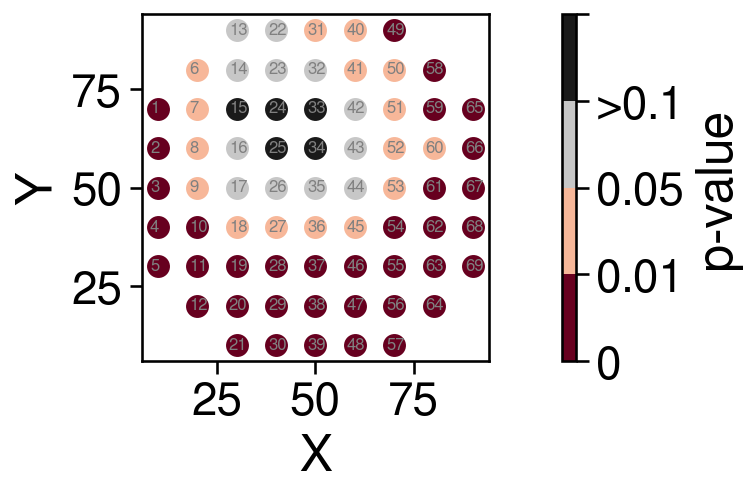

In [202]:

fig, (ax1, ax2) = plt.subplots(figsize=(4, 3),
                               ncols=2, gridspec_kw={'width_ratios': [3, 0.1]}, dpi=150)

# plot the fixed intervals
cmap = cm.RdGy(np.linspace(0, 1, 4))  # RdBu/RdGy

c_0_01 = [i for i, v in enumerate(z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.01]
c_0_05 = [i for i, v in enumerate(
    z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.05 and v >= 0.01]
c_0_1 = [i for i, v in enumerate(
    z_C_new_FeCrNiMoTi_Mahl_label) if v < 0.1 and v >= 0.05]
c_abv_0_1 = [i for i, v in enumerate(
    z_C_new_FeCrNiMoTi_Mahl_label) if v >= 0.1]

cax1 = ax1.scatter(PVD_x_y["x"][c_0_01],    PVD_x_y["y"][c_0_01],
                   color=cmap[0], s=400, marker='.')  # ,vmin=0.2, vmax=0.6
cax2 = ax1.scatter(PVD_x_y["x"][c_0_05],    PVD_x_y["y"][c_0_05],
                   color=cmap[1], s=400, marker='.')  # ,vmin=0.2, vmax=0.6
cax3 = ax1.scatter(PVD_x_y["x"][c_0_1],     PVD_x_y["y"][c_0_1],
                   color=cmap[2], s=400, marker='.')  # ,vmin=0.2, vmax=0.6
cax4 = ax1.scatter(PVD_x_y["x"][c_abv_0_1], PVD_x_y["y"][c_abv_0_1],
                   color=cmap[3], s=400, marker='.')  # ,vmin=0.2, vmax=0.6

ax1.set_aspect('equal', 'box')
for i, txt in enumerate(PVD_x_y.index+1):
    ax1.annotate(txt, (PVD_x_y["x"][i]-2, PVD_x_y["y"]
                 [i]-1), color="grey", alpha=1, fontsize=8)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_title(KW_name+'_'+PT_name)


# customised colorbar: https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

cmap = mpl.cm.RdGy  # RdBu/RdGy
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=ax2, orientation='vertical',
                    label="p-value")
cbar.ax.set_yticklabels(['0', '0.01', '0.05', '>0.1', ''])

plt.show()